# Librarys

In [155]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
vectorizer = TfidfVectorizer()
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, ComplementNB
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [156]:
with open('df_reviews.pickle', 'rb') as f:
    df_reviews = pickle.load(f)

df_reviews_nonTwitter = df_reviews[df_reviews['Source']!='twitter']
df_reviews_twitter = df_reviews[df_reviews['Source']=='twitter']

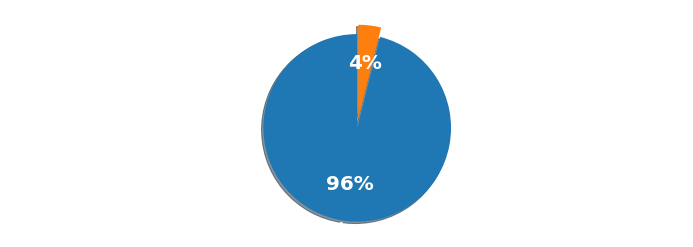

In [157]:
TotalRatedReviews = len(df_reviews_nonTwitter)
TotalNonRatedReviews = len(df_reviews_twitter)

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "Rated Reviews 'Grocery Sites'", "Twitter Reviews - Not Rated"
sizes = [TotalRatedReviews, TotalNonRatedReviews]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20, 'color':'white', 'weight':'heavy'})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [158]:
TotalNonRatedReviews

71

# Classification - Mixing Twitter and Retailer Reviews

In [168]:
X = df_reviews_nonTwitter['TextClean4']
y = df_reviews_nonTwitter['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


# MNB Params For Gridsearch
hyp_params_MNB = {
#     'vect__ngram_range': [(1,2)], #(1,2) - 84, 82
    'vect__min_df':[5], #2 - 87-.85
#     'vect__max_df':[100],
    'tfidf__use_idf': [False],# false = 87, 85
    'tfidf__norm': (['l1']),#L1
    'clf__alpha': [5000]#20,21, 25, 23... 22, 5, .01,.03, .05,
}
    

# classifer = ComplementNB()
classifer = MultinomialNB()

estimator = Pipeline([
        ('vect', TfidfVectorizer()),('tfidf', TfidfTransformer()),('sampling', SMOTE(random_state=1)),('clf', classifer)
    ])


hyp_params = hyp_params_MNB

cv=10
jobs = -1


grid = GridSearchCV(estimator=estimator, param_grid=hyp_params,scoring="recall",cv=cv, n_jobs=jobs)
grid_result = grid.fit(X_train, y_train)

  
modelscore_Train = round(grid_result.score(X_train, y_train),2)
modelscore_Test = round(grid_result.score(X_test, y_test),2)


print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')   
print("Best Parameters: \n{}\n".format(grid_result.best_params_))

Train Score: 0.9
Test Score: 0.9
Best Parameters: 
{'clf__alpha': 5000, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__min_df': 5}



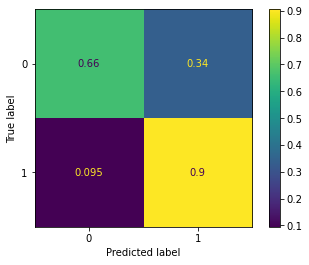

In [169]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
clf = grid_result.best_estimator_
plot_confusion_matrix(clf, X_test, y_test, normalize="true")  
plt.show()

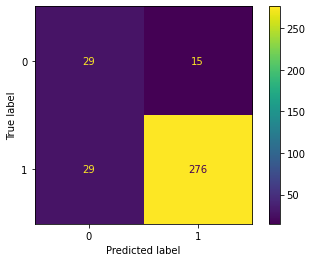

In [161]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
clf = grid_result.best_estimator_
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [162]:
# from IPython.display import HTML
# from IPython.core.interactiveshell import InteractiveShell
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pickle
import plotly.graph_objects as go


#Predictive Power Model 1
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = .93,
    #mode = "gauge+number+delta",
    mode = "gauge+number",
    title = {'text': "F1 Score"},
#     delta = {'reference': 1},
    gauge = {'axis': {'range': [None, 1]},
             'steps' : [
                 {'range': [0, 1], 'color': "white"},
                # {'range': [.35, .6], 'color': "lightgray"},
             #{'range': [.6, 1], 'color': "lightgreen"}
             ],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': .93}},
    number={"font":{"size":100}}))

fig.show()

# Classification - Splitting Twitter Reviews and Retailer Reviews

In [163]:
X_train = df_reviews_nonTwitter['TextClean4']
y_train = df_reviews_nonTwitter['Class']
X_test = df_reviews_twitter['TextClean4']
y_test = df_reviews_twitter['Class']

# MNB Params For Gridsearch
hyp_params_MNB = {
    'vect__ngram_range': [(2,2)], #(1,2) - 84, 82
    'vect__min_df':[2], #2 - 87-.85
#     'vect__max_df':[1000],
    'tfidf__use_idf': [False],# false = 87, 85
    'tfidf__norm': (['l1']),#L1
    'clf__alpha': [50]#20,21, 25, 23... 22, 5, .01,.03, .05,
}
    

classifer = ComplementNB()
# classifer = MultinomialNB()

estimator = Pipeline([
        ('vect', TfidfVectorizer()),('tfidf', TfidfTransformer()),('sampling', SMOTE(random_state=1)),('clf', classifer)
    ])


hyp_params = hyp_params_MNB

cv=10
jobs = -1


grid = GridSearchCV(estimator=estimator, param_grid=hyp_params,scoring="f1",cv=cv, n_jobs=jobs)
grid_result = grid.fit(X_train, y_train)

  
modelscore_Train = round(grid_result.score(X_train, y_train),2)
modelscore_Test = round(grid_result.score(X_test, y_test),2)


print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')   
print("Best Parameters: \n{}\n".format(grid_result.best_params_))

Train Score: 0.95
Test Score: 0.76
Best Parameters: 
{'clf__alpha': 50, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__min_df': 2, 'vect__ngram_range': (2, 2)}



In [164]:
# predictions = grid_result.predict(X_test)
#y_pred = grid_result.best_estimator_.predict(X)

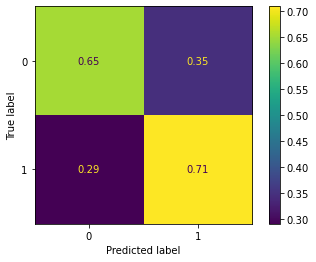

In [165]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
clf = grid_result.best_estimator_
plot_confusion_matrix(clf, X_test, y_test, normalize="true")  
plt.show()

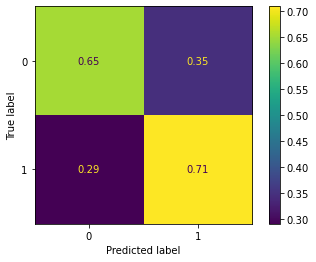

In [166]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
clf = grid_result.best_estimator_
plot_confusion_matrix(clf, X_test, y_test, normalize="true")  
plt.show()


In [167]:
# from IPython.display import HTML
# from IPython.core.interactiveshell import InteractiveShell
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pickle
import plotly.graph_objects as go


#Predictive Power Model 1
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = .95,
    #mode = "gauge+number+delta",
    mode = "gauge+number",
    title = {'text': "F1 Score"},
#     delta = {'reference': 1},
    gauge = {'axis': {'range': [None, 1]},
             'steps' : [
                 {'range': [0, 1], 'color': "white"},
                # {'range': [.35, .6], 'color': "lightgray"},
             #{'range': [.6, 1], 'color': "lightgreen"}
             ],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': .76}},
    number={"font":{"size":100}}))

fig.show()